<a href="https://colab.research.google.com/github/palashbaranwal/EVA4/blob/master/S6_MNIST/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


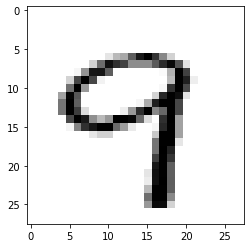

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

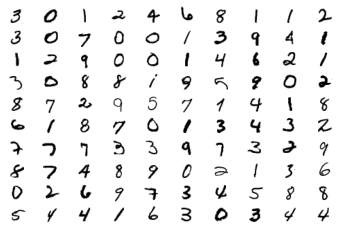

In [6]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm


class ModelTrain():
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    
  def train(self, model, device, train_loader, optimizer, epoch, scheduler, L1_reg=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)
      
      # Init
      optimizer.zero_grad()
      
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      
      # Predict
      y_pred = model(data)
      
      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if L1_reg == True:
        L1_factor = 0.000001
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1_factor * reg_loss
      self.train_losses.append(loss)
      
      # Backpropagation
      loss.backward()
      optimizer.step()
      
      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      
  def test(self, model, device, test_loader,filename):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)
      
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    self.test_acc.append(100. * correct / len(test_loader.dataset))

### Training Model without L1 and L2 Regularization

In [10]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model1 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model1.train(model, device, train_loader, optimizer, epoch, scheduler)
    model1.test(model, device, test_loader,"model1.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13423217833042145 Batch_id=468 Accuracy=91.56: 100%|██████████| 469/469 [00:10<00:00, 45.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9810/10000 (98.10%)

EPOCH: 1


Loss=0.14832507073879242 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:10<00:00, 45.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.03683150187134743 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:10<00:00, 45.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.047877922654151917 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 45.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.03940768167376518 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:10<00:00, 46.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.02716396190226078 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.05030721053481102 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:09<00:00, 48.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.052227336913347244 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:09<00:00, 48.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.06548592448234558 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:09<00:00, 48.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.016967400908470154 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:09<00:00, 47.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.020057836547493935 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:09<00:00, 47.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.03193612024188042 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:09<00:00, 47.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.00941002368927002 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 46.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.0062965997494757175 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 46.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.01522026490420103 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:09<00:00, 47.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.052086085081100464 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:09<00:00, 47.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.04200635477900505 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:09<00:00, 47.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.07225543260574341 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.003680666210129857 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 46.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.039760392159223557 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:10<00:00, 46.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 20


Loss=0.0018915435066446662 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:10<00:00, 46.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.0162323210388422 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:09<00:00, 47.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.011145800352096558 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:10<00:00, 46.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.003624518634751439 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:09<00:00, 47.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.0005209247465245426 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:10<00:00, 46.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.037059541791677475 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:10<00:00, 46.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 26


Loss=0.0012052655220031738 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:10<00:00, 46.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 27


Loss=0.014687280170619488 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:09<00:00, 47.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 28


Loss=0.02829049527645111 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:09<00:00, 46.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.002435743808746338 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:10<00:00, 46.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9954/10000 (99.54%)

EPOCH: 30


Loss=0.013574902899563313 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:09<00:00, 47.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.004068647976964712 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:09<00:00, 47.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.005022456403821707 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 46.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9952/10000 (99.52%)

EPOCH: 33


Loss=0.0006858209962956607 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:10<00:00, 46.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.017716819420456886 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:10<00:00, 46.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)

EPOCH: 35


Loss=0.001817410229705274 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:10<00:00, 46.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9947/10000 (99.47%)

EPOCH: 36


Loss=0.005390977021306753 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:09<00:00, 47.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 37


Loss=0.0060156830586493015 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:09<00:00, 47.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.018142158165574074 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:10<00:00, 45.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 39


Loss=0.011976629495620728 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s]



Test set: Average loss: 0.0167, Accuracy: 9951/10000 (99.51%)



### Training model with L1 regularization

In [13]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L1 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L1.train(model, device, train_loader, optimizer, epoch, scheduler, True)
    model_L1.test(model, device, test_loader,"model_L1.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13592590391635895 Batch_id=468 Accuracy=91.42: 100%|██████████| 469/469 [00:11<00:00, 41.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1011, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.061822421848773956 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:11<00:00, 41.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.02463868260383606 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.1100534051656723 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.053101763129234314 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 41.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.049302082508802414 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 42.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss=0.03383679687976837 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 41.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.015499094501137733 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 41.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.014040299691259861 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 41.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.13354213535785675 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 41.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.032845333218574524 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 41.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.05120601877570152 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.03841852769255638 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 42.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.022536829113960266 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.01777004636824131 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.04829738661646843 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.019330188632011414 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:11<00:00, 41.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.00400279788300395 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.024760961532592773 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.014622469432651997 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.0075822072103619576 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.0072713568806648254 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.004160220269113779 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.05690738931298256 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9951/10000 (99.51%)

EPOCH: 24


Loss=0.009058723226189613 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 41.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.01442426536232233 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9944/10000 (99.44%)

EPOCH: 26


Loss=0.018703557550907135 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 27


Loss=0.006785673554986715 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)

EPOCH: 28


Loss=0.0032899444922804832 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:11<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 9959/10000 (99.59%)

EPOCH: 29


Loss=0.016883818432688713 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.007150812074542046 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9958/10000 (99.58%)

EPOCH: 31


Loss=0.025256741791963577 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:11<00:00, 41.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 9965/10000 (99.65%)

EPOCH: 32


Loss=0.03947212174534798 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:11<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9958/10000 (99.58%)

EPOCH: 33


Loss=0.015992991626262665 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:11<00:00, 41.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9959/10000 (99.59%)

EPOCH: 34


Loss=0.002212502993643284 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:11<00:00, 42.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 9954/10000 (99.54%)

EPOCH: 35


Loss=0.007359569426625967 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 41.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9955/10000 (99.55%)

EPOCH: 36


Loss=0.016103841364383698 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 41.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 9957/10000 (99.57%)

EPOCH: 37


Loss=0.0032497451175004244 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9959/10000 (99.59%)

EPOCH: 38


Loss=0.0028484505601227283 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 41.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 9960/10000 (99.60%)

EPOCH: 39


Loss=0.006943074055016041 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]



Test set: Average loss: 0.0140, Accuracy: 9958/10000 (99.58%)



### Training model with L2 regularization

In [14]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.000001)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L2 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L2.train(model, device, train_loader, optimizer, epoch, scheduler)
    model_L2.test(model, device, test_loader,"model_L2.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08941910415887833 Batch_id=468 Accuracy=91.95: 100%|██████████| 469/469 [00:10<00:00, 44.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.06389154493808746 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.060521870851516724 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 45.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.12439075857400894 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:10<00:00, 43.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


Loss=0.05586707219481468 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.050281718373298645 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:10<00:00, 44.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.021692240610718727 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.05508321896195412 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.032434720546007156 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.02791524864733219 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 45.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.020476674661040306 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.01658015511929989 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.060419391840696335 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 45.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.009477739222347736 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 44.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.017095962539315224 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 44.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.0018995603313669562 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:10<00:00, 45.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.00918156374245882 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.016648033633828163 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 44.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.02367466688156128 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 45.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.1553332507610321 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 44.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.01115835178643465 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 45.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.0066688209772109985 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:10<00:00, 45.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.01665252447128296 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.05479136109352112 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.016103273257613182 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:10<00:00, 45.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.0034649670124053955 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 26


Loss=0.022145992144942284 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:10<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 27


Loss=0.049382779747247696 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:10<00:00, 44.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 28


Loss=0.009992520324885845 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:10<00:00, 44.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 29


Loss=0.018631046637892723 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 30


Loss=0.036413222551345825 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 43.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.004371965769678354 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.015091936103999615 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 33


Loss=0.021202608942985535 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 44.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 34


Loss=0.000719050585757941 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 43.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 35


Loss=0.05289800837635994 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 36


Loss=0.0025049846153706312 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.00115353858564049 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 44.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.0011503895511850715 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:10<00:00, 44.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 39


Loss=0.013646066188812256 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 44.38it/s]



Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)



### Training model with both L1 and L2 regularization

In [15]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.000001)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L1_L2 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L1_L2.train(model, device, train_loader, optimizer, epoch, scheduler, True)
    model_L1_L2.test(model, device, test_loader,"model_L1_L2.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13851957023143768 Batch_id=468 Accuracy=90.07: 100%|██████████| 469/469 [00:11<00:00, 40.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1357, Accuracy: 9726/10000 (97.26%)

EPOCH: 1


Loss=0.094551220536232 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.04019855707883835 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:12<00:00, 38.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.10695549845695496 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.023164765909314156 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.1853954941034317 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.024223513901233673 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.018100839108228683 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 40.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.01216261088848114 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 40.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.019259534776210785 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 41.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.030618103221058846 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.006225225981324911 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.07340394705533981 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 41.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.06659097969532013 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.008632645010948181 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 41.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.016344401985406876 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.007788548246026039 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.010450167581439018 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.004076281562447548 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.016534216701984406 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 41.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.017737509682774544 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 42.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.006533598527312279 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.008158707991242409 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 42.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.03950889781117439 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:11<00:00, 41.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.00491888914257288 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 41.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.006005133502185345 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.015948394313454628 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.019058896228671074 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.017773393541574478 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9948/10000 (99.48%)

EPOCH: 29


Loss=0.05092689022421837 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:12<00:00, 38.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.009184540249407291 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.011334178037941456 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.010272154584527016 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.008157631382346153 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 34


Loss=0.006153540685772896 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 35


Loss=0.05226743221282959 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

EPOCH: 36


Loss=0.00776843074709177 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:11<00:00, 39.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.00239176070317626 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 40.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.030142858624458313 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 39


Loss=0.012790580280125141 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]



Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)



# Plotting validation accuracy of all 4 models

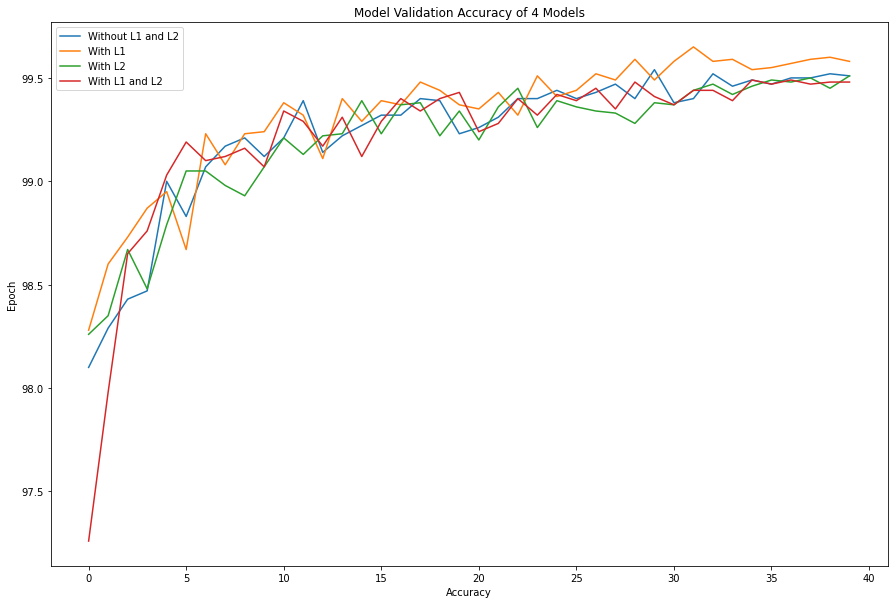

In [16]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_acc)
ax.plot(model_L1.test_acc)
ax.plot(model_L2.test_acc)
ax.plot(model_L1_L2.test_acc)
ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Without L1 and L2', 'With L1', 'With L2', 'With L1 and L2'], loc='best')
plt.savefig("Accuracyof4models.png")
plt.show()


In [0]:
### Plotting validation loss of four models

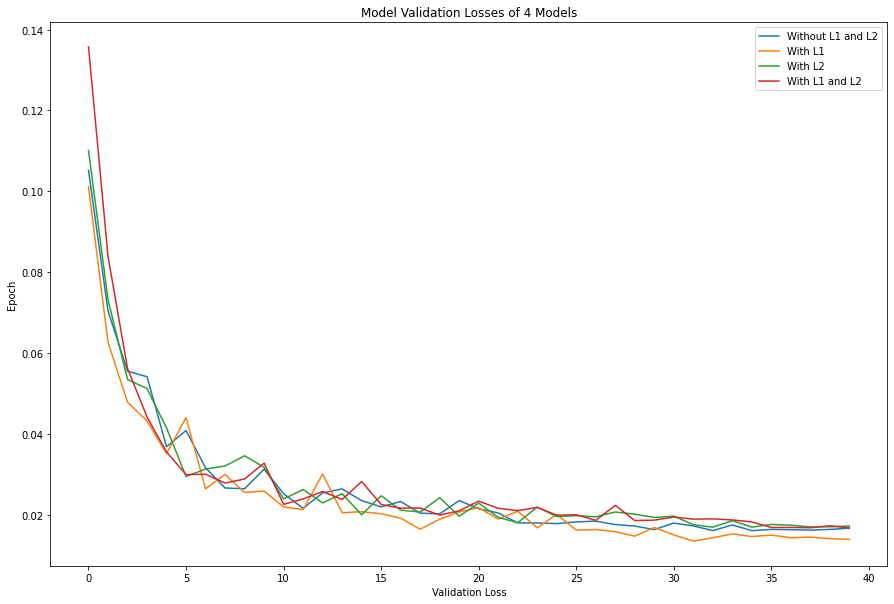

In [18]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_losses)
ax.plot(model_L1.test_losses)
ax.plot(model_L2.test_losses)
ax.plot(model_L1_L2.test_losses)
ax.set(title="Model Validation Losses of 4 Models", xlabel="Validation Loss", ylabel="Epoch")
ax.legend(['Without L1 and L2', 'With L1', 'With L2', 'With L1 and L2'], loc='best')
plt.savefig("ValidationLossof4models.png")
plt.show()

### Function to plot misclassified Images 

In [0]:
def PlotMisclassifiedImages(model, filename):
  
  model = model.to(device)
  # obtain one batch of test images
  dataiter = iter(test_loader)
  c=0
  fig = plt.figure(figsize=(14,14 ))
  
  while c<25:
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)  # get sample outputs

    _, preds = torch.max(output, 1)   # convert output probabilities to predicted class
    images = images.cpu().numpy() # prep images for display
    
    for idx in np.arange(128):
      if preds[idx]!=labels[idx] :
        ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
        c=c+1
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("P-{} (T-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
        if c==25:
          break
    plt.savefig(filename)



### Misclaassified images by model1 (without L1 and L2 regularization)